In [1]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Defaults
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams.update({'font.size': 36})
plt.style.use('ggplot')

In [2]:
NSW_crash = pd.read_csv('NSW_crash_clean.csv', index_col=0)

In [3]:
NSW_crash.head()

,Crash ID,Degree of crash,Degree of crash - detailed,Year of crash,Month of crash,Day of week of crash,Latitude,Longitude,LGA,Urbanisation,Conurbation 1,Surface condition,Weather,Speed limit,Road classification (admin),hour,Injuries,Date of crash
0,1088679,Fatal,Fatal,2016,January,Saturday,-32.830075,148.293512,Parkes,Country non-urban,Rest of NSW - Rural,Dry,Fine,100,Local,1,1,2016-01-01
1,1088682,Fatal,Fatal,2016,January,Monday,-35.800954,150.132066,Eurobodalla,Country non-urban,Rest of NSW - Rural,Wet,Raining,100,State,21,1,2016-01-01
2,1088829,Non-casualty (towaway),Non-casualty (towaway),2016,January,Friday,-34.031609,151.067157,Sutherland,Sydney metro. area,Syd-Newc-Woll Gtr conurbation,Dry,Fine,70,State,13,0,2016-01-01
3,1088867,Non-casualty (towaway),Non-casualty (towaway),2016,January,Friday,-33.847025,150.967695,Cumberland,Sydney metro. area,Syd-Newc-Woll Gtr conurbation,Dry,Fine,50,Local,13,0,2016-01-01
4,1088880,Non-casualty (towaway),Non-casualty (towaway),2016,January,Friday,-33.873753,151.212595,Sydney,Sydney metro. area,Syd-Newc-Woll Gtr conurbation,Wet,Fine,50,Regional,17,0,2016-01-01


In [4]:
monthly_crash = NSW_crash.groupby(by = 'Date of crash')['Crash ID'].count()

In [5]:
monthly_crash = monthly_crash.reset_index()
monthly_crash['Date of crash'] = pd.to_datetime(monthly_crash['Date of crash'], infer_datetime_format=True)
indexedDataset = monthly_crash.set_index(['Date of crash'])


In [6]:
indexedDataset.head()

,Crash ID
Date of crash,
2016-01-01,2047
2016-02-01,2070
2016-03-01,2190
2016-04-01,2185
2016-05-01,2383


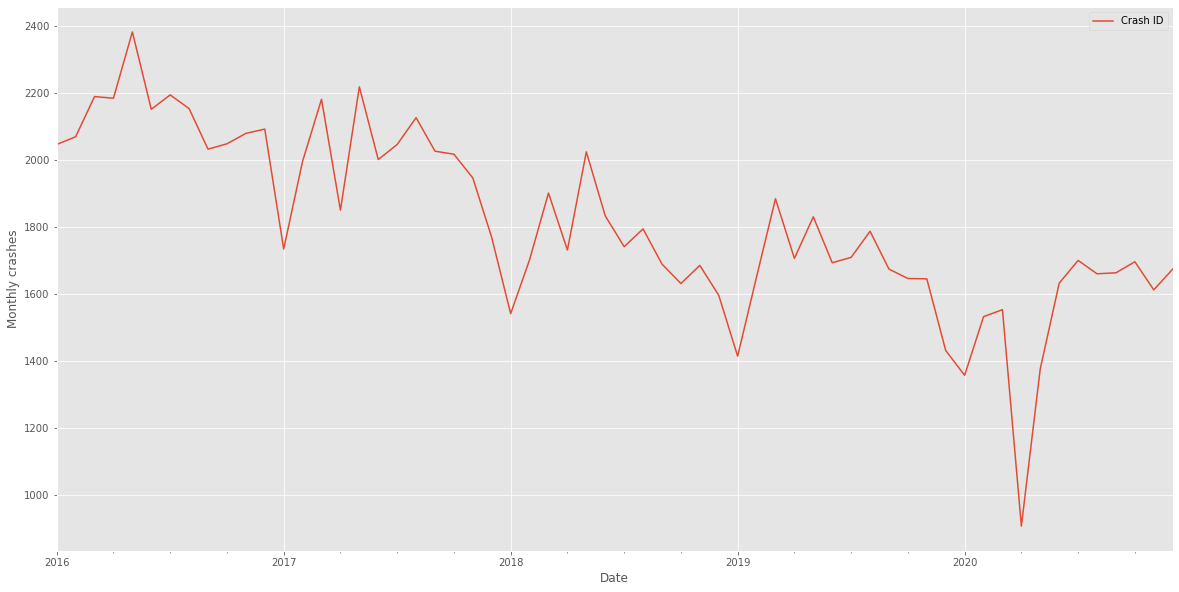

In [7]:
# Plot the data
indexedDataset.plot()
plt.ylabel('Monthly crashes')
plt.xlabel('Date')
plt.show()

In [8]:
train_data = indexedDataset['2016-01-01':'2019-12-01']
test_data = indexedDataset['2020-01-01':'2020-12-01']

In [9]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [10]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [11]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))


The smallest AIC is 8.0 for model SARIMAX(0, 0, 0)x(3, 1, 0, 12)


In [12]:
# Let's fit this model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_invertibility=False)

results = mod.fit()

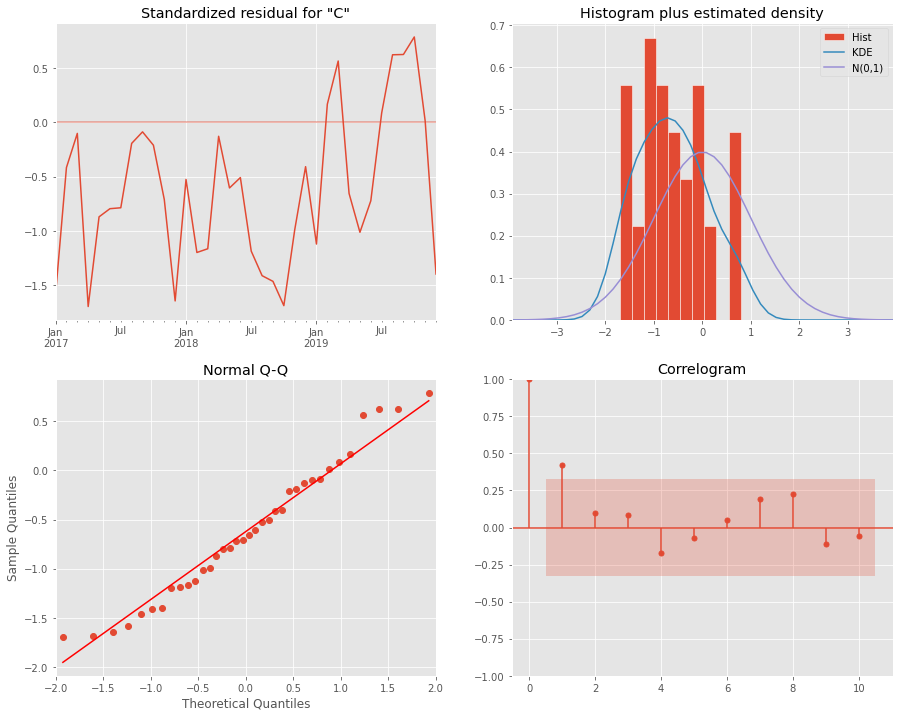

In [13]:
results.plot_diagnostics(figsize=(15, 12)) 
plt.show()



In [14]:
pred0 = results.get_prediction(start='2018-01-01', dynamic=False)
pred0_ci = pred0.conf_int()


In [15]:
pred1 = results.get_prediction(start='2018-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

In [16]:
pred2 = results.get_forecast('2022-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['2020-01-01':'2020-12-01'])

2020-01-01    1809.375048
2020-02-01    1827.582101
2020-03-01    1984.457488
2020-04-01    2070.906657
2020-05-01    2102.670174
2020-06-01    1929.069827
2020-07-01    1955.524050
2020-08-01    1919.022997
2020-09-01    1789.700753
2020-10-01    1792.485099
2020-11-01    1865.717168
2020-12-01    1841.973137
Freq: MS, Name: predicted_mean, dtype: float64


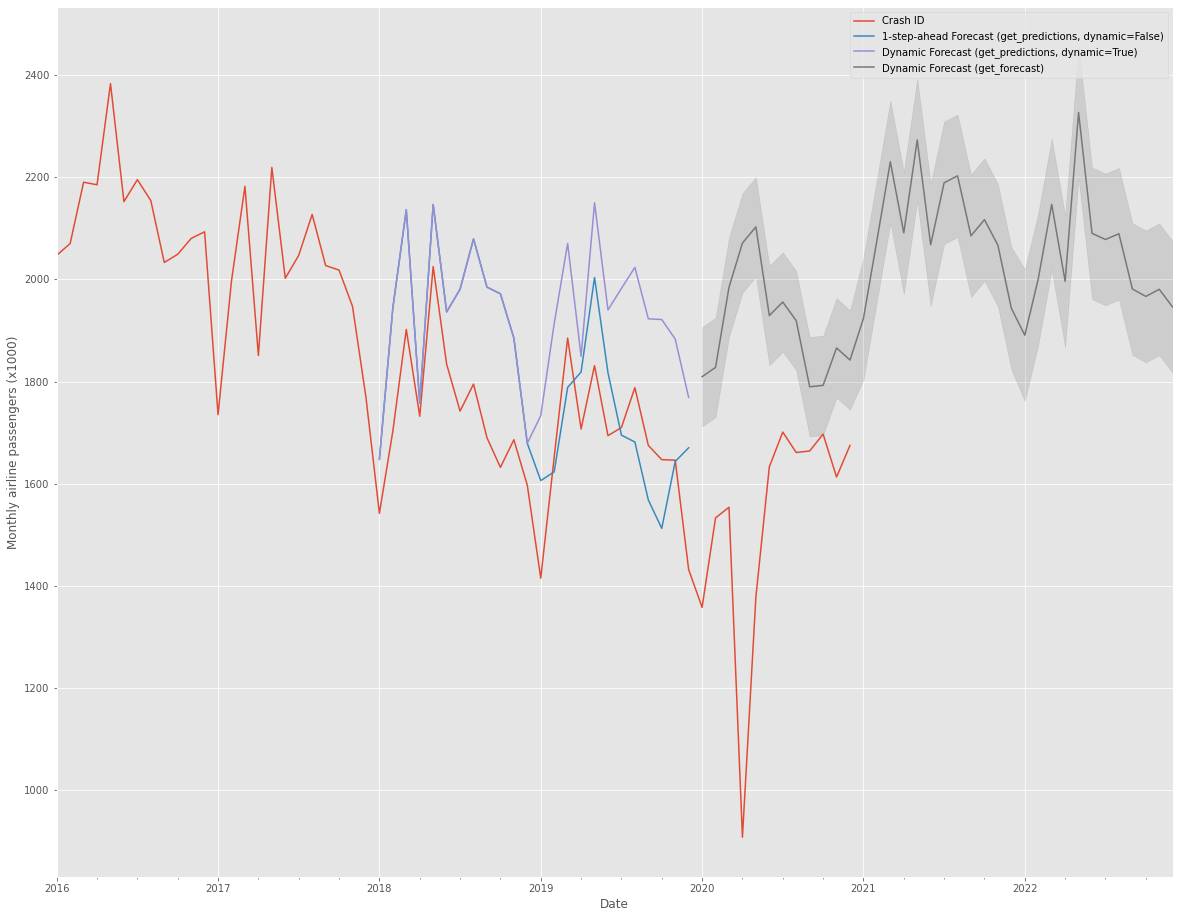

In [17]:
ax = indexedDataset.plot(figsize=(20, 16))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

In [18]:
prediction = pred2.predicted_mean['2020-01-01':'2020-12-01'].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 1960 is {:.2f}%'.format(MAPE))

The Mean Absolute Percentage Error for the forecast of year 1960 is 29.02%


In [19]:
print(prediction)

[1809.3750484  1827.58210112 1984.45748763 2070.90665745 2102.67017416
 1929.06982749 1955.52404986 1919.02299741 1789.70075305 1792.48509884
 1865.71716808 1841.9731371 ]


In [20]:
dataLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
dataLogScaleMinusMovingAverage.dropna(inplace=True)
dataLogScaleMinusMovingAverage.head()

NameError: name 'indexedDataset_logScale' is not defined

In [ ]:
test_stationary(dataLogScaleMinusMovingAverage)

In [ ]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale, 'blue')
plt.plot(exponentialDecayWeightedAverage, 'red')

In [ ]:
dataLogScaleMinusMovingExponentialDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationary(dataLogScaleMinusMovingExponentialDecayAverage)

In [ ]:
dataLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(dataLogDiffShifting, color='blue')
dataLogDiffShifting.dropna(inplace=True)
test_stationary(dataLogDiffShifting)



fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
plot_acf(dataLogDiffShifting, lags=20, ax=axes[0], alpha=0.5)
plot_pacf(dataLogDiffShifting, lags=20, ax=axes[1], alpha=0.5)
plt.tight_layout()

In [ ]:
model = ARIMA(indexedDataset_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(dataLogDiffShifting, color='blue')
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %4f'% sum((results_ARIMA.fittedvalues - dataLogDiffShifting['#Passengers'])**2))
print('Plotting ARIMA model')